# World of Warcraft 

Data source from: [kaggle](https://www.kaggle.com/datasets/mylesoneill/warcraft-avatar-history?resource=download)

EDA


In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from src.utils import prep_parquet

In [2]:
sns.set_palette("muted")

Conver CSV to Parquet For better performance

In [3]:
org_csv_file_path = "./data/wowah_data.csv"
parquet_file_path = "./data/wowah_data.parquet"

if os.path.exists(parquet_file_path):
    wowah = pd.read_parquet("./data/wowah_data.parquet")
else:
    prep_parquet(org_csv_file_path, playtime=1)
    wowah = pd.read_parquet("./data/wowah_data.parquet")

wowah.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,2008-01-01 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,2008-01-01 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,2008-01-01 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,2008-01-01 00:02:09


In [4]:
# Columns 7 
# Rows 10,817,778
wowah.shape

(10817778, 7)

Join `Zones` with player data

In [5]:
zones_df = pd.read_csv("./data/zones.csv")
zones_df.head()

,Zone_Name,Continent,Area,Zone,Subzone,Type,Size,Controlled,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
0,Durotar,Kalimdor,Central Kalimdor,Durotar,NaN,Zone,NaN,Horde,1,1.0,10.0,1.0,10.0
1,The Barrens,Kalimdor,Central Kalimdor,The Barrens,NaN,Zone,NaN,Contested,1,10.0,35.0,10.0,35.0
2,Silverpine Forest,Eastern Kingdoms,Lordaeron,Silverpine Forest,NaN,Zone,NaN,Horde,1,10.0,20.0,10.0,20.0
3,Stonetalon Mountains,Kalimdor,Central Kalimdor,Stonetalon Mountains,NaN,Zone,NaN,Contested,1,25.0,30.0,25.0,30.0
4,Thunder Bluff,Kalimdor,Central Kalimdor,Thunder Bluff,NaN,City,NaN,Horde,1,1.0,100.0,1.0,100.0


In [6]:
zones_df.isnull().sum()

Zone_Name          0
Continent          0
Area               3
Zone               7
Subzone          108
Type               0
Size              92
Controlled         0
Min_req_level      0
Min_rec_level      1
Max_rec_level      1
Min_bot_level      2
Max_bot_level      2
dtype: int64

In [7]:
# Subzone and Szie have null
# Since the categorical infromation can't be guessed
# Drop the columns
zones_df.drop(["Subzone", "Size"], axis=1, inplace=True)

In [8]:
# There are missing data
# The columns - Area, Zone, Min_bot_level, Max_bot_level
# Also drop the rows
zones_df[zones_df["Zone"].isnull()]
zones_df = zones_df.dropna()

In [9]:
# Select Zone, Area, Continent, Type and Cotrolled
# And chance column names to lower chartacter 
zones_small_df = zones_df[["Zone", "Area", "Continent", "Type", "Controlled"]].rename(columns={"Zone":"zone"})
zones_small_df = zones_small_df.set_index("zone")
zones_small_df.head()

,Area,Continent,Type,Controlled
zone,,,,
Durotar,Central Kalimdor,Kalimdor,Zone,Horde
The Barrens,Central Kalimdor,Kalimdor,Zone,Contested
Silverpine Forest,Lordaeron,Eastern Kingdoms,Zone,Horde
Stonetalon Mountains,Central Kalimdor,Kalimdor,Zone,Contested
Thunder Bluff,Central Kalimdor,Kalimdor,City,Horde


In [10]:
# Join data zones_small_df and wowah
# df = pd.merge(wowah, zones_small_df, left_on="zone", right_on="Zone", how="inner")
df = wowah.join(zones_small_df, on="zone", how="inner")
print(df.info(), "\n",df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18259581 entries, 0 to 10817286
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   char        int64         
 1   level       int64         
 2   race        object        
 3   charclass   object        
 4   zone        object        
 5   guild       int64         
 6   timestamp   datetime64[ns]
 7   Area        object        
 8   Continent   object        
 9   Type        object        
 10  Controlled  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.6+ GB
None 
 (18259581, 11)


In [11]:
def ch_Dtype_categorical(df, col_names: list):
    for col_name in col_names:
        df[col_name] = df[col_name].astype("object")

ch_Dtype_categorical(df, ["char", "level", "guild"])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18259581 entries, 0 to 10817286
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   char        object        
 1   level       object        
 2   race        object        
 3   charclass   object        
 4   zone        object        
 5   guild       object        
 6   timestamp   datetime64[ns]
 7   Area        object        
 8   Continent   object        
 9   Type        object        
 10  Controlled  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 1.6+ GB


## Understand features

Analysis around data distribution 


Q: How many unique players?

A: 28,398 players

In [12]:
len(df["char"].unique()) # 28398 -> 15990

27681

`level`

Q: How many unique levels?

A: 80

In [13]:
print(len(df["level"].unique()))

80


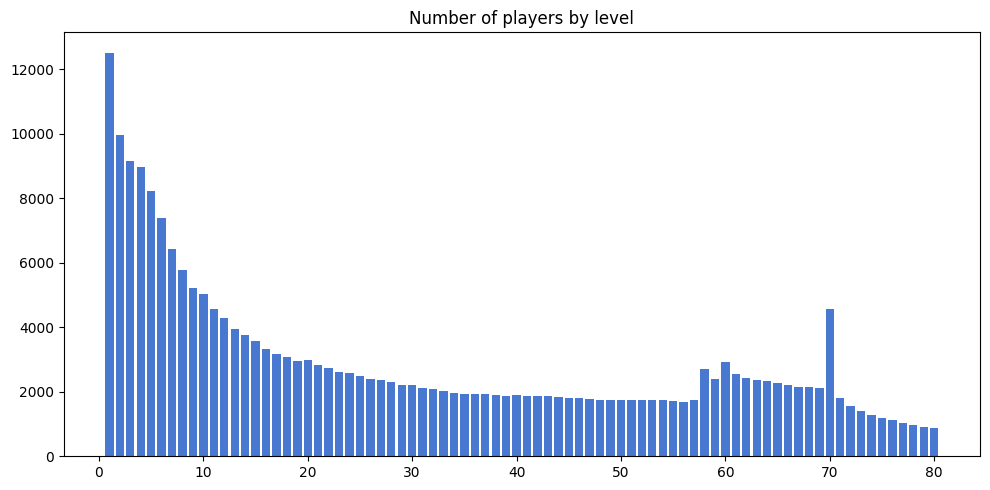

In [124]:
# number of players by level
plt.figure(figsize=(10,5))
plt.bar(df.groupby(["char","level"]).size().groupby("level").size().index, df.groupby(["char","level"]).size().groupby("level").size().values)
plt.title("Number of players by level")
plt.tight_layout()
plt.savefig("./images/bar_number_of_players_by_level.png")

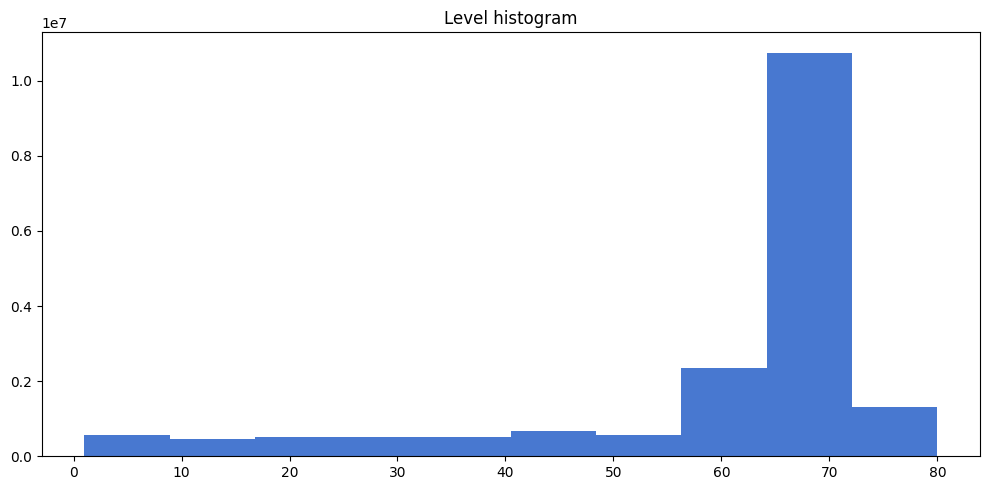

In [126]:
# number of players by level
plt.figure(figsize=(10,5))
plt.hist(df['level'])
plt.title("Level histogram")
plt.tight_layout()
plt.savefig("./images/hist_level.png")

Before November 2008, the maximum level a player could reach in World of Warcraft was 70. 

However, with the launch of the Wrath of the Lich King expansion in November 2008, the level cap was raised to 80.

`race`

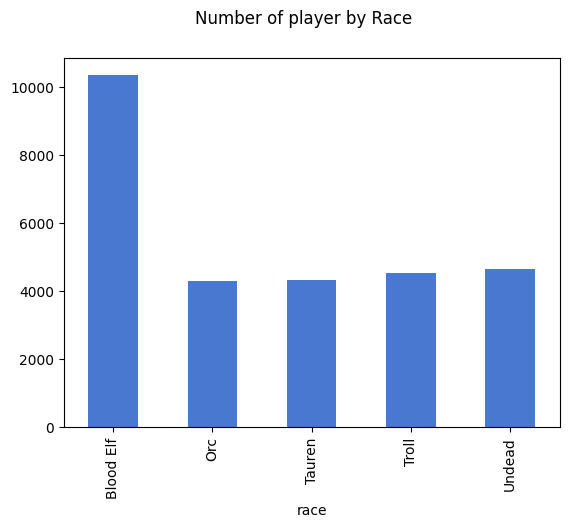

In [15]:
unique_race_char = df.groupby(["char", "race"]).size()
bar_race = unique_race_char.groupby("race").size().plot.bar()
bar_race.figure.suptitle("Number of player by Race")
bar_race.figure.savefig("./images/bar_race.png")

level race

In [16]:
df.query("race == 'Blood Elf'").groupby(["race", "level"]).size().unstack().loc["Blood Elf"]

level
1      15069
2       9650
3       8679
4      11180
5      14239
       ...  
76     41402
77     28856
78     22462
79     16941
80    146138
Name: Blood Elf, Length: 80, dtype: int64

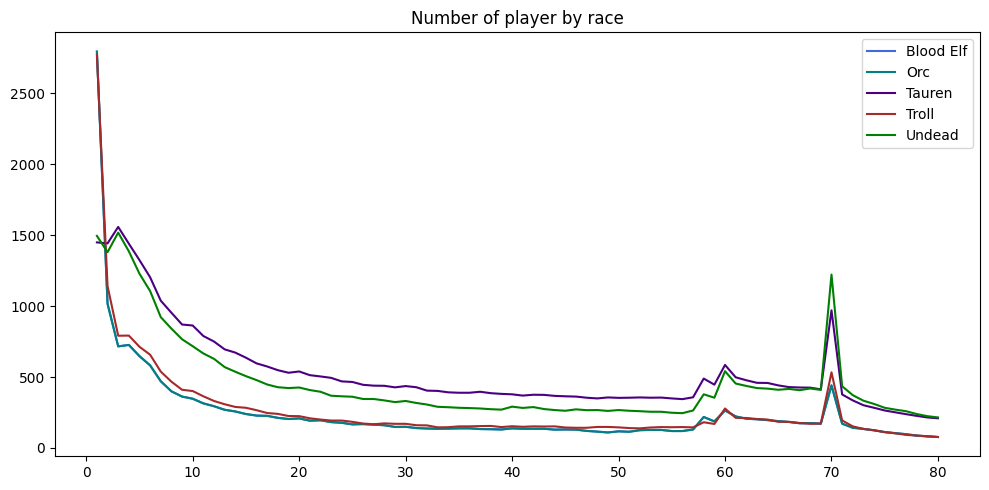

In [73]:
num_player_race = df.groupby(["char","race", "level"]).size().reset_index()[["char","race","level"]].groupby(["race", "level"]).size().unstack()

plt.figure(figsize=(10, 5))
plt.plot(num_player_race.loc["Orc"], 'royalblue', label="Blood Elf")
plt.plot(num_player_race.loc["Orc"], 'teal', label="Orc")
plt.plot(num_player_race.loc["Tauren"], 'indigo', label="Tauren")
plt.plot(num_player_race.loc["Troll"], 'brown', label="Troll")
plt.plot(num_player_race.loc["Undead"], 'green', label="Undead")
plt.title("Number of player by race")
plt.tight_layout()
plt.legend()
plt.savefig("./images/line_number_of_players_by_level_race.png")
plt.show()

`charclass`

In [87]:
df["charclass"].value_counts().values

array([2839014, 2396749, 2275319, 2056595, 1908723, 1776207, 1731582,
       1470586, 1201559,  603247], dtype=int64)

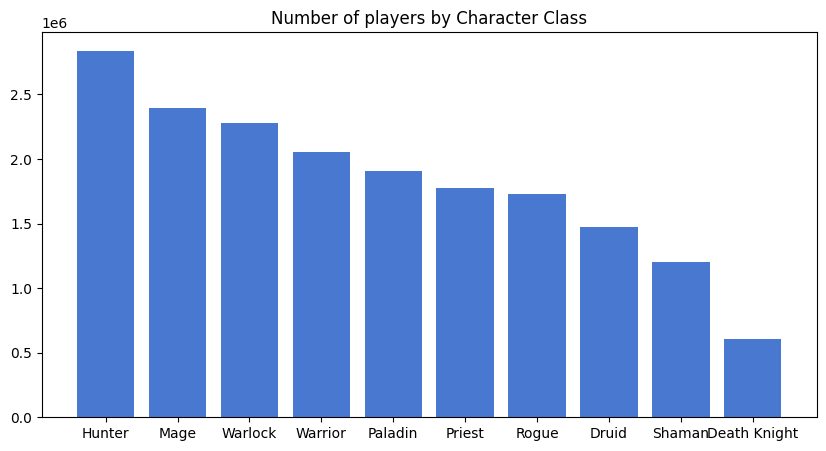

In [88]:
plt.figure(figsize=(10, 5))
plt.bar(df["charclass"].value_counts().index, df["charclass"].value_counts().values)
plt.title("Number of players by Character Class")
plt.tight_layout()
plt.savefig("./images/bar_number_of_players_by_char_class.png")
plt.show()

`zone`

There are unique 158 zones

`Area`

There are unique 8 areas

`Continent`

There are unique 5 contients

`Type`

There are 7 different types of map type

C:\Users\hyssh\AppData\Local\Temp\ipykernel_29668\3176282446.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels=df["Area"].value_counts().index, rotation=45)


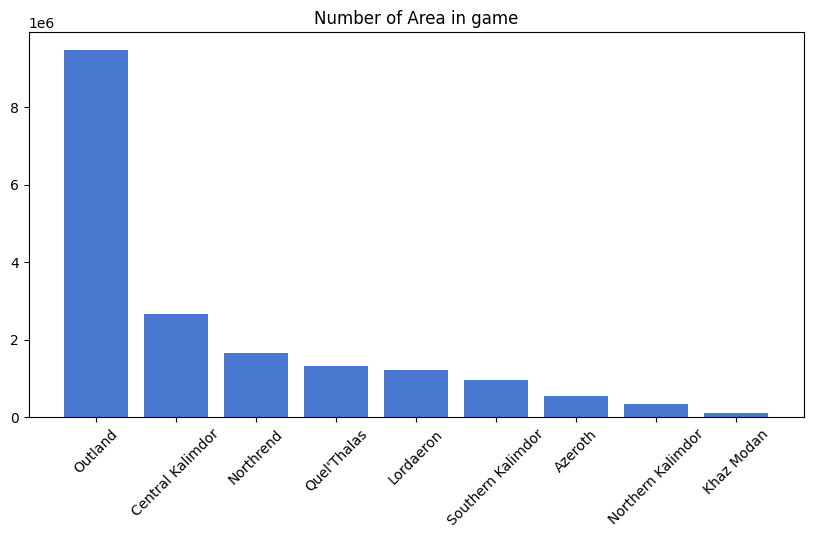

In [92]:
plt.figure(figsize=(10, 5))
plt.bar(df["Area"].value_counts().index, df["Area"].value_counts().values)
plt.title("Number of Area in game")
plt.savefig("./images/bar_number_of_area_in_game.png")
plt.gca().set_xticklabels(labels=df["Area"].value_counts().index, rotation=45)
plt.tight_layout()
plt.show()

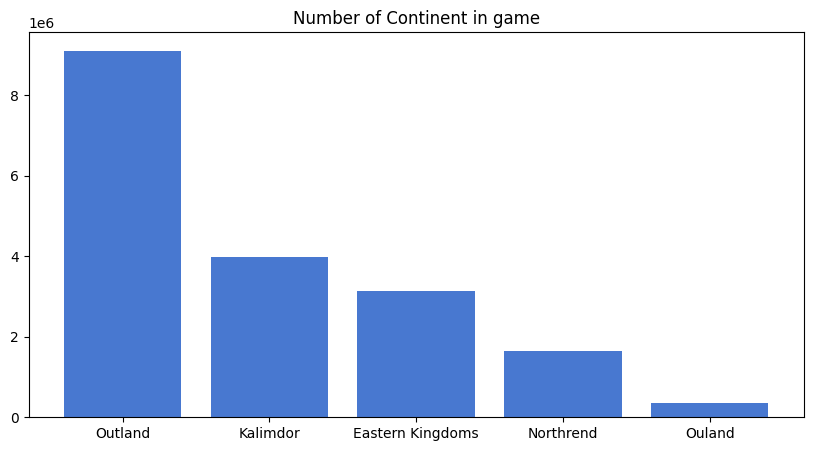

In [93]:
plt.figure(figsize=(10, 5))
plt.bar(df["Continent"].value_counts().index, df["Continent"].value_counts().values)
plt.title("Number of Continent in game")
plt.gca().set_xticklabels(labels=df["Continent"].value_counts().index, rotation=45)
plt.tight_layout()
plt.savefig("./images/bar_number_of_continent_in_game.png")
plt.show()

C:\Users\hyssh\AppData\Local\Temp\ipykernel_29668\2994104779.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels=df["Type"].value_counts().index, rotation=45)


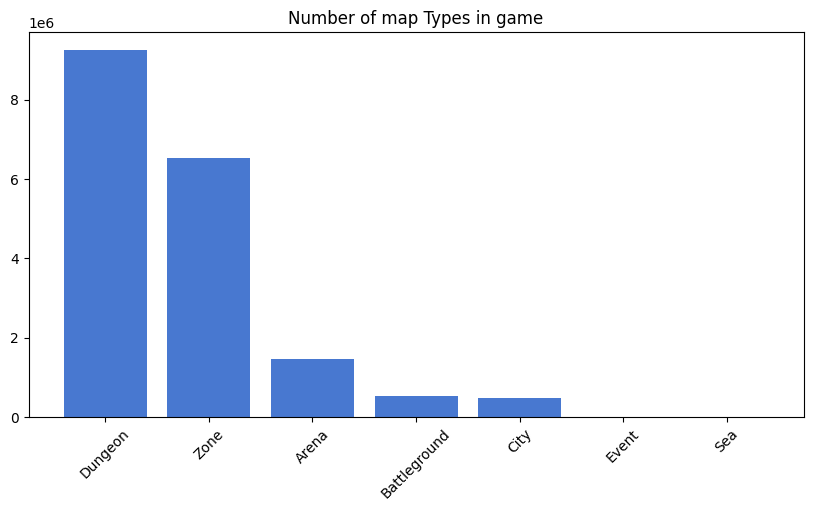

In [96]:
plt.figure(figsize=(10, 5))
plt.bar(df["Type"].value_counts().index, df["Type"].value_counts().values)
plt.title("Number of map Types in game")
plt.gca().set_xticklabels(labels=df["Type"].value_counts().index, rotation=45)
plt.tight_layout()
plt.savefig("./images/bar_number_of_map_types_in_game.png")
plt.show()

`guild`

392 unique guild

`-1` represent no guild

- Does player play game more when they joined a guild?
- How often they join and leave a guild?

In [118]:
df.groupby(["guild"]).size().sort_values(ascending=False).head(10).index.astype(str)

Index(['-1', '103', '282', '101', '161', '104', '189', '35', '53', '62'], dtype='object', name='guild')

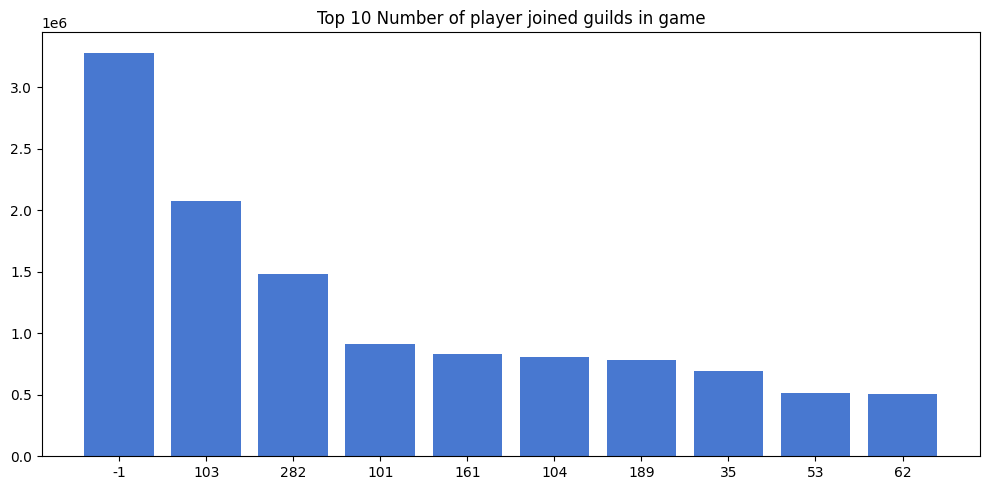

In [119]:
# print(len(df["guild"].unique()))
plt.figure(figsize=(10, 5))
plt.bar(df.groupby(["guild"]).size().sort_values(ascending=False).head(10).index.astype(str), df.groupby(["guild"]).size().sort_values(ascending=False).head(10).values)
plt.title("Top 10 Number of player joined guilds in game")
plt.tight_layout()
plt.savefig("./images/bar_number_of_player_join.png")
plt.show()

How the play time different by the each guid?

`timestamp`

A year long data
- min : 2008-01-01 00:02:04 
- max : 2008-12-31 23:50:18 

In [23]:
print("min :",df["timestamp"].min(), "\nmax :",df["timestamp"].max(),"\nmean:", df["timestamp"].mean())

min : 2008-01-01 00:02:04 
max : 2008-12-31 23:50:18 
mean: 2008-06-17 10:14:14.133756160


Remove players who has only 1 record

- We can use the player data to understand the early churn of players

In [24]:
print("From ", np.min(df["timestamp"]), "to", np.max(df["timestamp"]))

From  2008-01-01 00:02:04 to 2008-12-31 23:50:18


In [25]:
print("Number of unique players", len(df["char"].unique()))

Number of unique players 27681


In [26]:
df["year"] = df["timestamp"].apply(lambda x: pd.Timestamp(x).year)
df["month"] = df["timestamp"].apply(lambda x: pd.Timestamp(x).month)
df["day"] = df["timestamp"].apply(lambda x: pd.Timestamp(x).day)
df.head()

,char,level,race,charclass,zone,guild,timestamp,Area,Continent,Type,Controlled,year,month,day
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04,Central Kalimdor,Kalimdor,Dungeon,Horde,2008,1,1
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04,Central Kalimdor,Kalimdor,Arena,PvP,2008,1,1
12,33256,70,Orc,Warrior,Orgrimmar,53,2008-01-01 00:02:19,Central Kalimdor,Kalimdor,Dungeon,Horde,2008,1,1
12,33256,70,Orc,Warrior,Orgrimmar,53,2008-01-01 00:02:19,Central Kalimdor,Kalimdor,Arena,PvP,2008,1,1
13,22307,70,Orc,Warrior,Orgrimmar,174,2008-01-01 00:02:19,Central Kalimdor,Kalimdor,Dungeon,Horde,2008,1,1


Number of player over time

Wow offers 3 diffenent subscriptions

- 1 month, $ 14.99/month
- 3 months, $ 13.99/month
- 6 months, $ 12.99/month

Free trial up to level 20


In [27]:
play_duration_per_player_df = df.groupby(["char","race"]).agg({"timestamp":["min","max"]}).reset_index()
play_duration_per_player_df["playduration"] = (play_duration_per_player_df["timestamp"]["max"] - play_duration_per_player_df["timestamp"]["min"]).astype('timedelta64[M]').astype(int) + 1
play_duration_per_player_df

char       race           timestamp                     playduration
                                        min                 max             
0          7        Orc 2008-01-15 21:47:09 2008-12-28 23:06:41           12
1          9        Orc 2008-01-01 11:02:20 2008-06-27 09:35:07            6
2         10        Orc 2008-07-06 17:23:25 2008-11-07 20:33:59            5
3         19        Orc 2008-01-07 03:01:19 2008-12-29 01:35:10           12
4         21        Orc 2008-01-01 00:32:25 2008-12-27 15:46:09           12
...      ...        ...                 ...                 ...          ...
28144  90572  Blood Elf 2008-12-31 20:18:10 2008-12-31 23:48:36            1
28145  90573      Troll 2008-12-31 20:31:18 2008-12-31 21:31:18            1
28146  90575        Orc 2008-12-31 20:59:51 2008-12-31 21:14:51            1
28147  90576  Blood Elf 2008-12-31 22:06:58 2008-12-31 23:07:13            1
28148  90577  Blood Elf 2008-12-31 22:17:35 2008-12-31 22:47:54            1

[28149 rows x 5 columns]

Player has one or more characters

For example, player 22095 has three characters and play the game in total 8 months

In [28]:
play_duration_per_player_df[play_duration_per_player_df["char"] == 22095]

char       race           timestamp                     playduration
                                       min                 max             
2854  22095  Blood Elf 2008-01-02 21:14:48 2008-04-25 00:36:59            4
2855  22095        Orc 2008-04-25 00:53:34 2008-07-22 14:50:21            3
2856  22095      Troll 2008-01-02 20:53:39 2008-01-02 21:03:28            1

88 players have two or more characters

In [29]:
play_duration_per_player_df.groupby(["char", "race"]).size().groupby(["char"]).size()[play_duration_per_player_df.groupby(["char", "race"]).size().groupby(["char"]).size()>1]

char
383      2
789      2
870      2
2612     2
2776     2
        ..
89937    3
90098    2
90112    2
90440    2
90522    2
Length: 434, dtype: int64

How may players been played the game 12 months

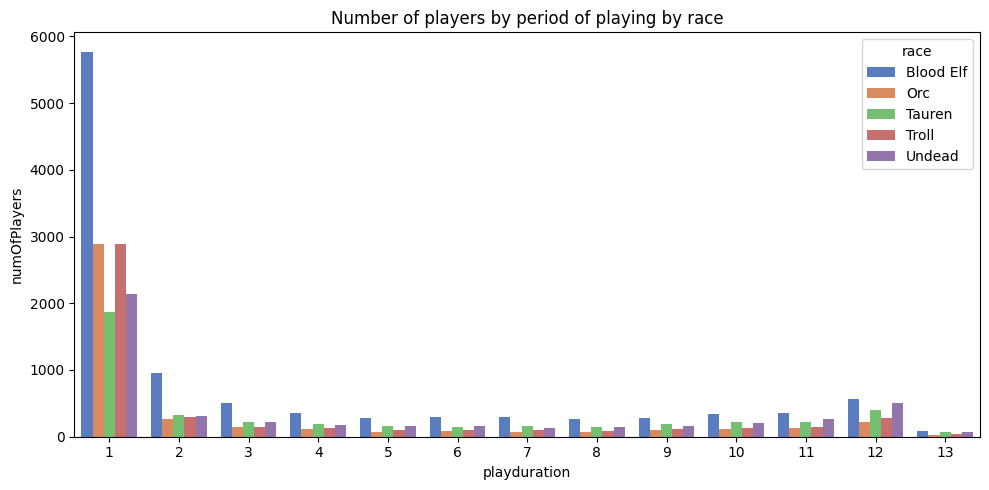

In [151]:
play_duration_per_player_race_by_month_df = play_duration_per_player_df.groupby(["playduration","race"]).size().reset_index().rename(columns={0:"numOfPlayers"})
play_duration_per_player_race_by_month_df

plt.figure(figsize=(10, 5))
sns.barplot(play_duration_per_player_race_by_month_df, x="playduration", y="numOfPlayers", hue="race")
plt.title("Number of players by period of playing by race")
plt.tight_layout()
plt.savefig("./images/bar_number_of_players_by_play_duration_by_race.png")

In [31]:
play_duration_per_player_df.groupby("char").sum("playduration")

C:\Users\hyssh\AppData\Local\Temp\ipykernel_29668\771513065.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  play_duration_per_player_df.groupby("char").sum("playduration")


,playduration
,
char,
7,12
9,6
10,5
19,12
21,12
...,...
90572,1
90573,1


In [32]:
play_duration_per_player_df.groupby("char").sum("playduration")

C:\Users\hyssh\AppData\Local\Temp\ipykernel_29668\771513065.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  play_duration_per_player_df.groupby("char").sum("playduration")


,playduration
,
char,
7,12
9,6
10,5
19,12
21,12
...,...
90572,1
90573,1


In [132]:
play_duration_per_player_race_by_month_df.groupby(["playduration"]).sum("numOfPlayers")

,numOfPlayers
playduration,
1,15548
2,2143
3,1240
4,956
5,775
6,787
7,755
8,711
9,835


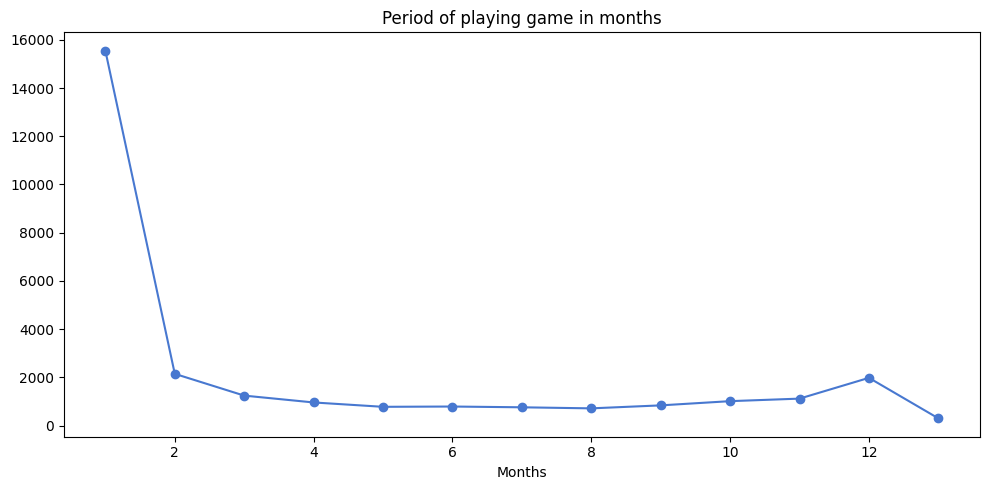

In [139]:
plt.figure(figsize=(10, 5))
# sns.lineplot(data=play_duration_per_player_race_by_month_df, x="playduration", y="numOfPlayers")
ax = plt.plot(play_duration_per_player_race_by_month_df.groupby(["playduration"]).sum("numOfPlayers").index, play_duration_per_player_race_by_month_df.groupby(["playduration"]).sum("numOfPlayers"), "o-")
plt.title("Period of playing game in months")
plt.xlabel("Months")
plt.tight_layout()
plt.savefig("./images/line_period_of_playing_in_month.png")

In [34]:
# play_duration_per_player_df[play_duration_per_player_df["timestamp"]["min"] < "2008-12-01 00:00:00"]
# # .query("min > 2008-12-31")#["playduration"].value_counts()

In [35]:
play_duration_per_player_df["playduration"].sort_values(ascending=False)

4908     13
457      13
2493     13
3973     13
2486     13
         ..
15638     1
15639     1
15641     1
15645     1
28148     1
Name: playduration, Length: 28149, dtype: int32

How frequency play the game 
- Average play times

In [36]:
AVERAGEPLAYCOUNT = int(np.mean(df.groupby(["char"]).size()))
print(f"Average number of play time is {AVERAGEPLAYCOUNT}")

Average number of play time is 659


In [37]:
print(len(df.groupby(["char"]).size()[df.groupby(["char"]).size() > AVERAGEPLAYCOUNT]), "players are played the game more than", AVERAGEPLAYCOUNT, "times.")

5029 players are played the game more than 659 times.


In [38]:
# get the most top 10 players
top10players = df.groupby(["char"]).size().sort_values(ascending=False).index[:10]
top10players

Int64Index([182, 1384, 62239, 62085, 61105, 59489, 57741, 69535, 62446, 24126], dtype='int64', name='char')

<AxesSubplot:xlabel='level', ylabel='0'>

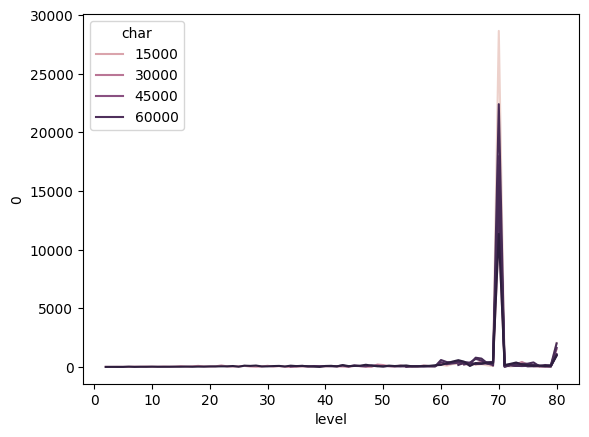

In [39]:
top10player_history = df.query("char in @top10players")
top10player_history.groupby(["char", "level"]).size().reset_index().query("level != 1")#.unstack().plot.bar(stacked=True, figsize=(16,10))
sns.lineplot(data=top10player_history.groupby(["char", "level"]).size().reset_index().query("level != 1"), x="level", y=0, hue="char")

In [40]:
# get the player who is played the game most

theplayer = df.groupby(["char"]).size()[df.groupby(["char"]).size() == 42801]
# df[df["char"]==10].groupby(["char", "level"]).size()

Number of New player each month

In [41]:
(df.groupby(["char", "race"]).apply(lambda x: x["timestamp"].min())).info()

<class 'pandas.core.series.Series'>
MultiIndex: 28149 entries, (7, 'Orc') to (90577, 'Blood Elf')
Series name: None
Non-Null Count  Dtype         
--------------  -----         
28149 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 518.8+ KB


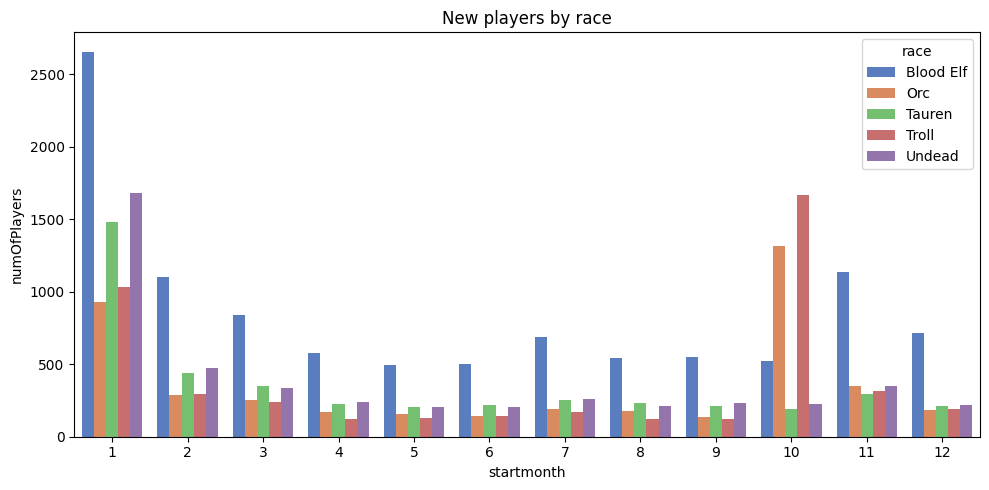

In [148]:
plt.figure(figsize=(10,5))
# begin_month = df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].min()).month).reset_index().rename(columns={0:"startmonth"}).groupby(["startmonth"]).size().plot.line()
first_month_player_race = df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].min()).month).reset_index().rename(columns={0:"startmonth"}).groupby(["startmonth", "race"]).size().reset_index().rename(columns={0:"numOfPlayers"})
sns.barplot(first_month_player_race, x="startmonth", y="numOfPlayers", hue="race")
plt.title("New players by race")
plt.tight_layout()
plt.savefig("./images/bar_new_players_by_race.png")

Last seen player data may not be useful because we can get this data in real-life

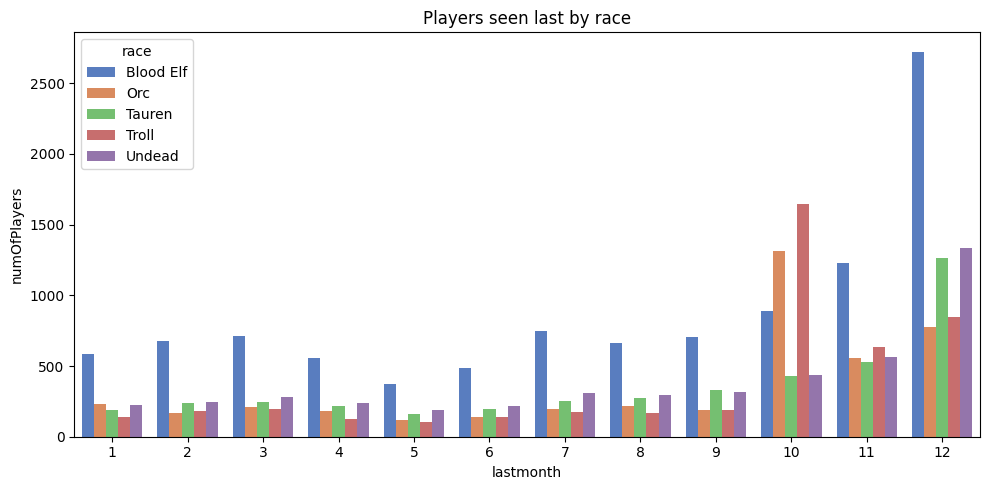

In [149]:
plt.figure(figsize=(10,5))
last_month_player_race = df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].max()).month).reset_index().rename(columns={0:"lastmonth"}).groupby(["lastmonth", "race"]).size().reset_index().rename(columns={0:"numOfPlayers"})
sns.barplot(last_month_player_race, x="lastmonth", y="numOfPlayers", hue="race")
plt.title("Players seen last by race")
plt.tight_layout()
plt.savefig("./images/bar_players_last_seen_by_race.png")

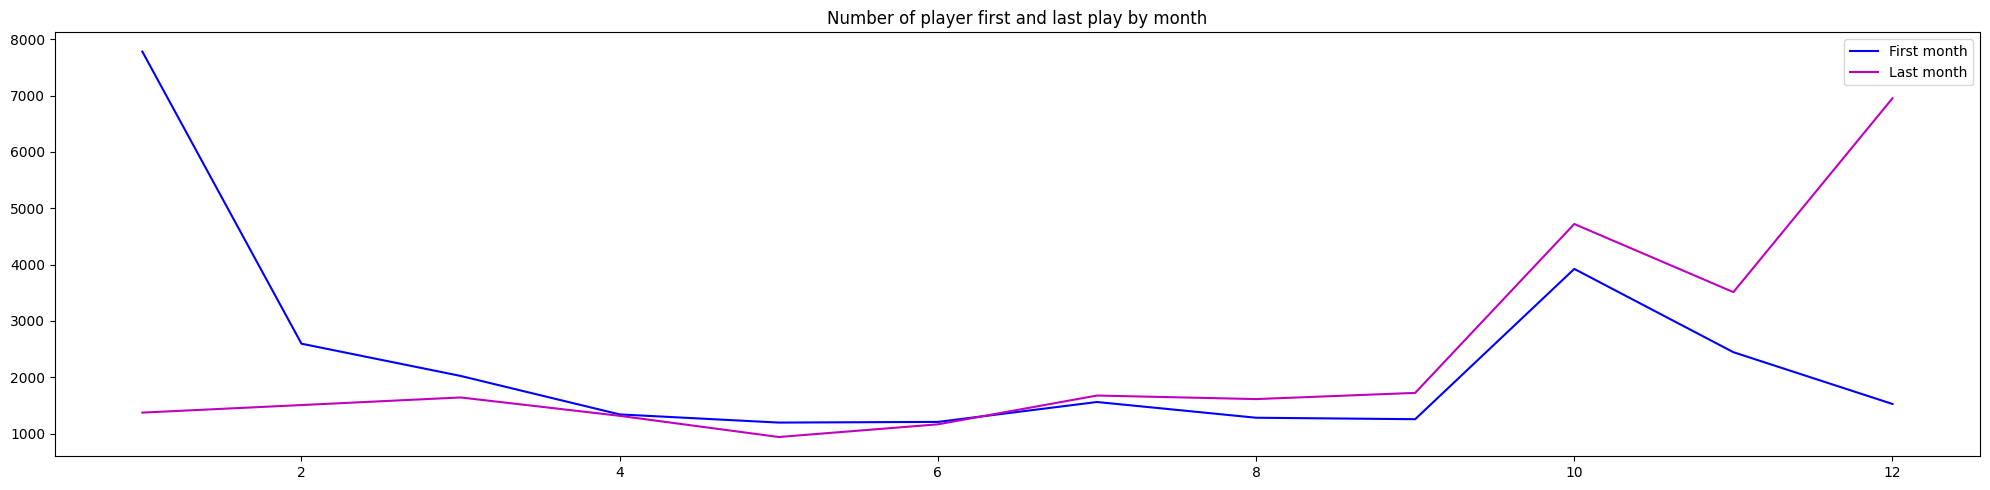

In [146]:
plt.figure(figsize=(10,5))
plt.title("Number of player first and last play by month")
plt.plot(df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].min()).month).reset_index().rename(columns={0:"firstmonth"}).groupby(["firstmonth"]).size(), 'b-', label="First month")
plt.plot(df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].max()).month).reset_index().rename(columns={0:"lastmonth"}).groupby(["lastmonth"]).size(), 'm-', label="Last month")
plt.legend()
plt.tight_layout()
plt.savefig("./images/line_First_and_Last_Player_by_Month.png")
plt.show()

In [45]:
first_month = df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].min()).month).reset_index().rename(columns={0:"firstmonth"})

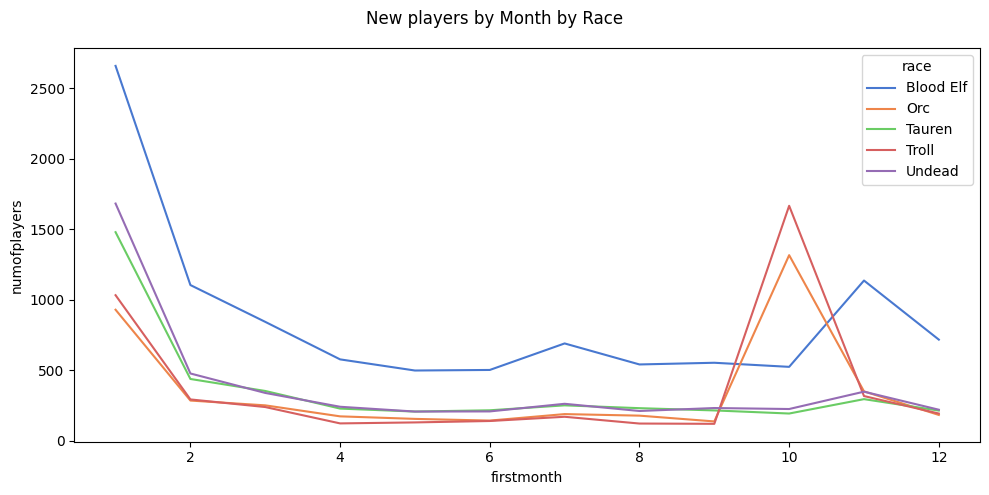

In [147]:
line_numOfPlayers_by_month_race = sns.lineplot(data=first_month.groupby(["race", "firstmonth"]).size().reset_index().rename(columns={0:"numofplayers"}), x="firstmonth", y="numofplayers", hue="race")
line_numOfPlayers_by_month_race.figure.suptitle("New players by Month by Race")
line_numOfPlayers_by_month_race.figure.set_size_inches((10,5))
plt.tight_layout()
line_numOfPlayers_by_month_race.figure.savefig("./images/line_numOfPlayer_by_Month_by_Race.png")

In [47]:
last_month = df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].max()).month).reset_index().rename(columns={0:"lastmonth"})

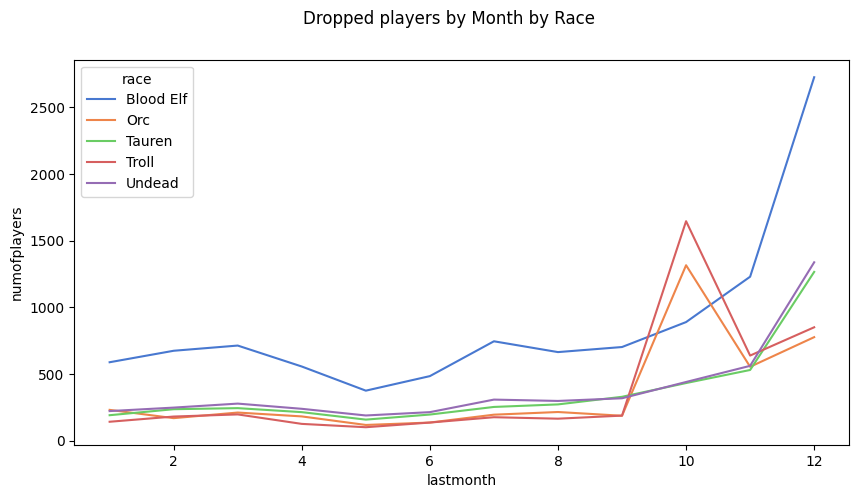

In [150]:
line_numOfPlayers_by_month_race = sns.lineplot(data=last_month.groupby(["race", "lastmonth"]).size().reset_index().rename(columns={0:"numofplayers"}), x="lastmonth", y="numofplayers", hue="race")
line_numOfPlayers_by_month_race.figure.suptitle("Dropped players by Month by Race")
line_numOfPlayers_by_month_race.figure.set_size_inches((10,5))
line_numOfPlayers_by_month_race.figure.savefig("./images/line_numOf_Dropped_Player_by_Month_by_Race.png")

In [49]:
df.head()

,char,level,race,charclass,zone,guild,timestamp,Area,Continent,Type,Controlled,year,month,day
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04,Central Kalimdor,Kalimdor,Dungeon,Horde,2008,1,1
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04,Central Kalimdor,Kalimdor,Arena,PvP,2008,1,1
12,33256,70,Orc,Warrior,Orgrimmar,53,2008-01-01 00:02:19,Central Kalimdor,Kalimdor,Dungeon,Horde,2008,1,1
12,33256,70,Orc,Warrior,Orgrimmar,53,2008-01-01 00:02:19,Central Kalimdor,Kalimdor,Arena,PvP,2008,1,1
13,22307,70,Orc,Warrior,Orgrimmar,174,2008-01-01 00:02:19,Central Kalimdor,Kalimdor,Dungeon,Horde,2008,1,1


Find number of Zone and Guild for the players  

In [50]:
# df.groupby(["char","zone","guild"])["char", "zone"].value_counts()#.size().reset_index().groupby(["char"]).count()
# df.groupby(["char"])[["zone", "guild"]].agg({"zone":"value_counts", "guild":"value_counts"})
# df.groupby(["char"])[["zone", "guild"]].value_counts().head(10)
player_char_race_zone_guild_df= df.groupby(["char","race"])[["zone","guild"]].nunique().rename(columns={"guild":"numOfJoinedGuild"})
player_char_race_zone_guild_df

,,zone,numOfJoinedGuild
char,race,,
7,Orc,38,2
9,Orc,43,2
10,Orc,31,1
19,Orc,24,3
21,Orc,50,2
...,...,...,...
90572,Blood Elf,1,1
90573,Troll,1,1
90575,Orc,2,1


Number of record (or play) for the player

In [51]:
player_char_play_count_df = df.groupby(["char", "race"]).nunique()[["timestamp"]].rename(columns={"timestamp":"playcount"})
player_char_play_count_df

,,playcount
char,race,
7,Orc,593
9,Orc,1504
10,Orc,550
19,Orc,1710
21,Orc,863
...,...,...
90572,Blood Elf,12
90573,Troll,5
90575,Orc,2


Find how long the player been playing the game

```python
play_duration_per_player_df = df.groupby(["char","race"]).agg({"timestamp":["min","max"]}).reset_index()
play_duration_per_player_df["playduration"] = (play_duration_per_player_df["timestamp"]["max"] - play_duration_per_player_df["timestamp"]["min"]).astype('timedelta64[M]').astype(int) + 1
play_duration_per_player_df
```

In [52]:
# play_duration_per_player_df.droplevel(level=1, axis=1).rename(columns=)
play_duration_per_player_df = df.groupby(["char","race"]).agg({"timestamp":["min","max"]}).reset_index()
play_duration_per_player_df["playduration"] = (play_duration_per_player_df["timestamp"]["max"] - play_duration_per_player_df["timestamp"]["min"]).astype('timedelta64[M]').astype(int) + 1
play_duration_per_player_df

char       race           timestamp                     playduration
                                        min                 max             
0          7        Orc 2008-01-15 21:47:09 2008-12-28 23:06:41           12
1          9        Orc 2008-01-01 11:02:20 2008-06-27 09:35:07            6
2         10        Orc 2008-07-06 17:23:25 2008-11-07 20:33:59            5
3         19        Orc 2008-01-07 03:01:19 2008-12-29 01:35:10           12
4         21        Orc 2008-01-01 00:32:25 2008-12-27 15:46:09           12
...      ...        ...                 ...                 ...          ...
28144  90572  Blood Elf 2008-12-31 20:18:10 2008-12-31 23:48:36            1
28145  90573      Troll 2008-12-31 20:31:18 2008-12-31 21:31:18            1
28146  90575        Orc 2008-12-31 20:59:51 2008-12-31 21:14:51            1
28147  90576  Blood Elf 2008-12-31 22:06:58 2008-12-31 23:07:13            1
28148  90577  Blood Elf 2008-12-31 22:17:35 2008-12-31 22:47:54            1

[28149 rows x 5 columns]

In [53]:
player_char_playduration_df2 = play_duration_per_player_df.droplevel(level=1, axis=1)[["char","race", "playduration"]].set_index("char")
player_char_playduration_df2

,race,playduration
char,,
7,Orc,12
9,Orc,6
10,Orc,5
19,Orc,12
21,Orc,12
...,...,...
90572,Blood Elf,1
90573,Troll,1
90575,Orc,1


C:\Users\hyssh\AppData\Local\Temp\ipykernel_29668\1548218299.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


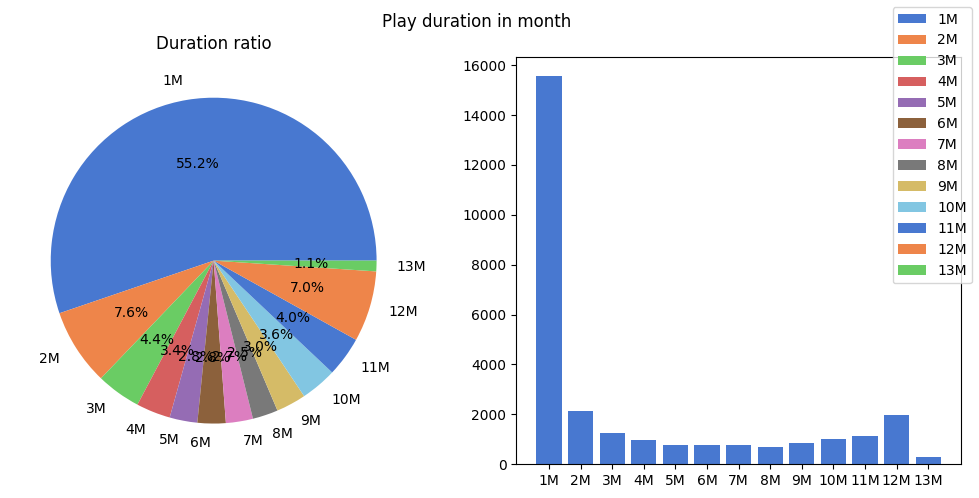

In [143]:
playduration_labels = ["1M","2M","3M","4M","5M","6M","7M","8M","9M","10M","11M","12M", "13M"]
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pie(x=player_char_playduration_df2.groupby(["playduration"]).size(), autopct="%.1f%%", labels=playduration_labels,labeldistance=1.12)
ax[0].set_title("Duration ratio")
ax[1].bar(x=playduration_labels, height=player_char_playduration_df2.groupby(["playduration"]).size())
fig.legend()
fig.suptitle("Play duration in month")
fig.savefig("./images/pie_bar_play_duration_in_month.png")
fig.tight_layout()
fig.show()

Find the player's Race, Charclass and mean level

In [55]:
player_char_race_charclass_level_df = df.groupby(["char","race","charclass"]).agg({"level":"mean"}).reset_index()
player_char_race_charclass_level_df = player_char_race_charclass_level_df.set_index("char")
player_char_race_charclass_level_df

,race,charclass,level
char,,,
7,Orc,Hunter,63.127588
9,Orc,Hunter,70.000000
10,Orc,Hunter,50.602446
19,Orc,Rogue,69.983255
21,Orc,Hunter,70.000000
...,...,...,...
90572,Blood Elf,Warlock,3.583333
90573,Troll,Shaman,3.600000
90575,Orc,Hunter,2.000000


Join the data

In [56]:
char_race_start_level_df = df.groupby(["char", "race"]).agg({"level":"min"}).rename(columns={"level":"start_level"})
# char_race_start_level_df = df.groupby(["char", "race"])["level"].min().reset_index(["char", "race"]).rename(columns={"level":"start_level"})
char_race_start_level_df

,,start_level
char,race,
7,Orc,54
9,Orc,70
10,Orc,29
19,Orc,69
21,Orc,70
...,...,...
90572,Blood Elf,1
90573,Troll,2
90575,Orc,2


In [57]:
char_race_start_month_df = df.groupby(["char", "race"]).apply(lambda x: pd.Timestamp(x["timestamp"].min()).month).reset_index().rename(columns={0:"start_month"}).set_index(["char","race"])
char_race_start_month_df

,,start_month
char,race,
7,Orc,1
9,Orc,1
10,Orc,7
19,Orc,1
21,Orc,1
...,...,...
90572,Blood Elf,12
90573,Troll,12
90575,Orc,12


In [58]:
# player_char_race_zone_guild_df
# player_char_zone_guild_df
play_recordes = player_char_race_zone_guild_df.\
    join(player_char_playduration_df2, on="char", how="inner").drop("race", axis=1).\
        join(player_char_race_charclass_level_df.reset_index().set_index(["char", "race"]), on=["char", "race"]).\
            join(player_char_play_count_df, on=["char", "race"], how="inner").\
            join(char_race_start_month_df, on=["char", "race"], how="inner").\
            join(char_race_start_level_df, on=["char", "race"], how="inner")

play_recordes = play_recordes.reindex(columns=['zone', 'numOfJoinedGuild', 'charclass', 'level','playcount', 'start_month','start_level', 'playduration'])
play_recordes.head()

,,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration
char,race,,,,,,,,
7,Orc,38,2,Hunter,63.127588,593,1,54,12
9,Orc,43,2,Hunter,70.000000,1504,1,70,6
10,Orc,31,1,Hunter,50.602446,550,7,29,5
19,Orc,24,3,Rogue,69.983255,1710,1,69,12
21,Orc,50,2,Hunter,70.000000,863,1,70,12


Text(0.5, 1.0, 'Pairplot for player record data by playduration')

<Figure size 2000x2000 with 0 Axes>

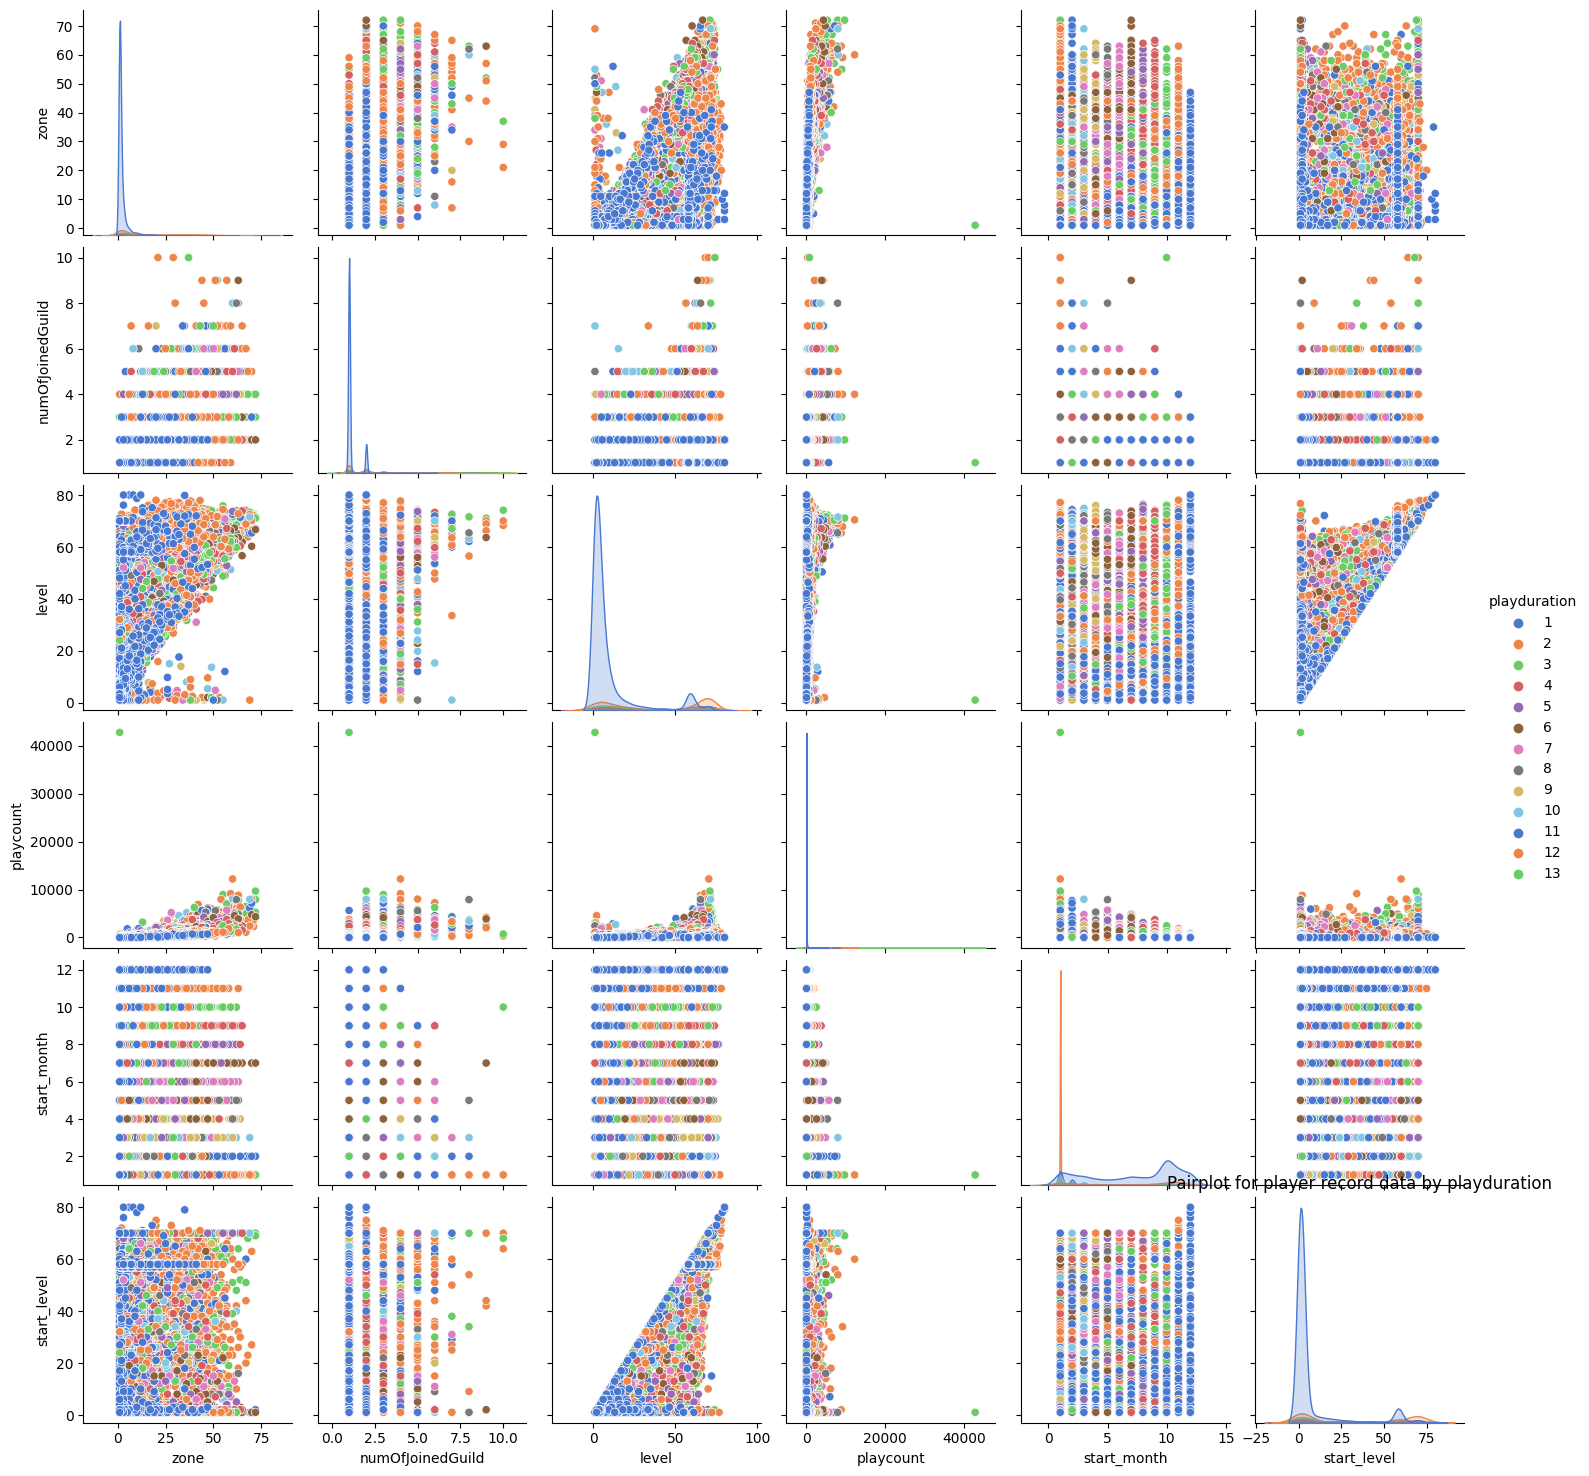

In [59]:
plt.figure(figsize=(20, 20))
sns.pairplot(play_recordes, hue="playduration", palette="muted")
plt.title("Pairplot for player record data by playduration")

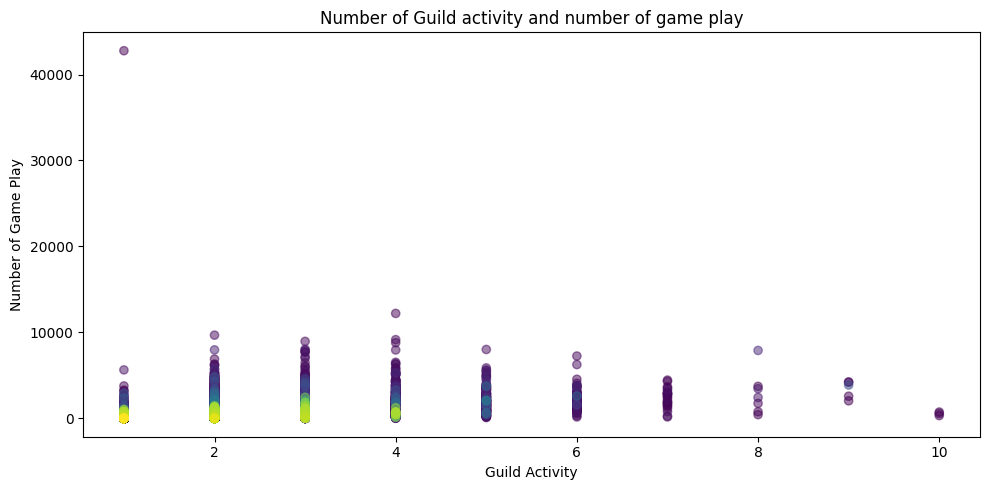

In [164]:
plt.figure(figsize=(10,5))
plt.scatter(play_recordes["numOfJoinedGuild"], play_recordes["playcount"], c=play_recordes["level"].sort_values(), alpha=0.5)
plt.title("Number of Guild activity and number of game play")
plt.xlabel("Guild Activity")
plt.ylabel("Number of Game Play")
plt.tight_layout()
plt.savefig("./images/scatter_numofJoinedGuild_palycount.png")

<AxesSubplot:xlabel='numOfJoinedGuild'>

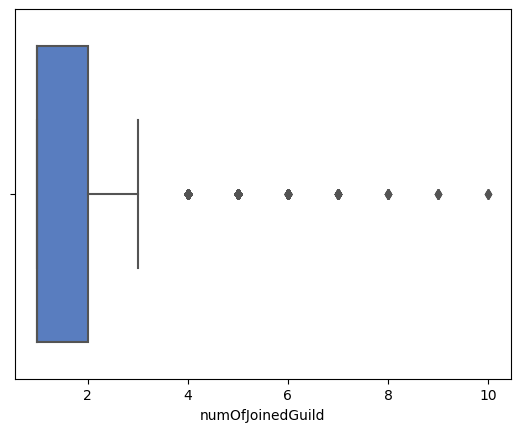

In [60]:
# sns.boxplot(play_recordes, x="playduration", y="playcount", palette="muted")
sns.boxplot(play_recordes, x="numOfJoinedGuild")

<AxesSubplot:xlabel='level'>

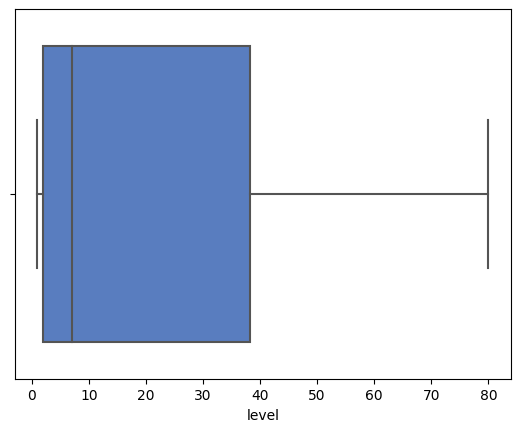

In [61]:
sns.boxplot(play_recordes, x="level")

<AxesSubplot:xlabel='playcount', ylabel='Count'>

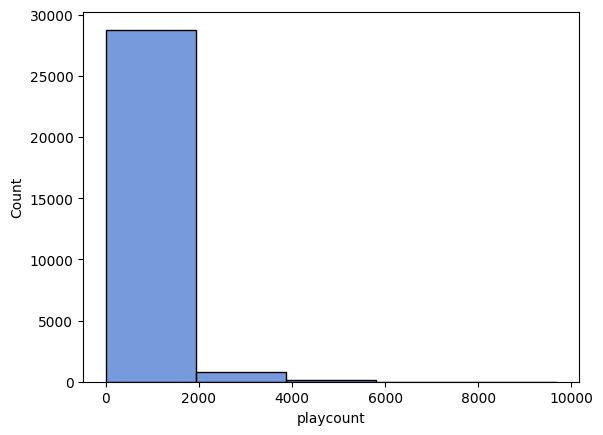

In [62]:
# sns.boxplot(play_recordes, x="playcount")
sns.histplot(play_recordes.query("playcount < 10000"), x="playcount", bins=5)

In [63]:
# df["char"].value_counts()
play_recordes.query("playcount > 7000 and playcount < 10000").sort_values("playcount", ascending=False)

,,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration
char,race,,,,,,,,
62239,Undead,72,2,Mage,71.084230,9681,1,69,13
59489,Blood Elf,59,4,Priest,67.821196,9157,1,34,12
57741,Undead,55,3,Warlock,71.056266,8956,1,70,13
24126,Blood Elf,63,4,Warlock,65.332967,8801,1,2,12
69535,Blood Elf,60,3,Warlock,64.887803,8045,3,1,10
62446,Blood Elf,70,5,Mage,70.178462,8013,1,63,12
70425,Orc,69,2,Warrior,71.491086,7967,3,70,10
62085,Tauren,54,4,Warrior,68.972984,7955,1,54,12
1003,Orc,72,3,Warrior,71.382609,7918,1,70,13


In [64]:
theUndead = df[df["char"] == 62239]
theElf = df[df["char"] == 59489]
theTauren = df[df["char"] == 62085]
theOrc = df[df["char"]== 70425]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


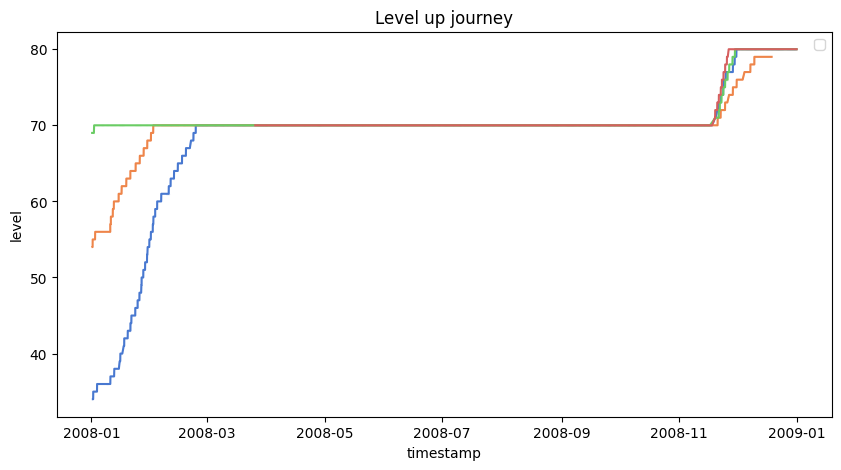

<Figure size 640x480 with 0 Axes>

In [212]:
plt.figure(figsize=(10,5))
ax1 = sns.lineplot(data=theElf, x="timestamp", y="level")
ax2 = sns.lineplot(data=theTauren, x="timestamp", y="level",ax=ax1)
ax3 = sns.lineplot(data=theUndead, x="timestamp", y="level", ax=ax2)
ax4 = sns.lineplot(data=theOrc, x="timestamp", y="level", ax=ax3)
plt.title("Level up journey")
plt.legend()
plt.show()
plt.savefig("./images/line_level_up_journey.png")

Save training data set `play_recordes`

In [66]:
play_recordes.head()

,,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration
char,race,,,,,,,,
7,Orc,38,2,Hunter,63.127588,593,1,54,12
9,Orc,43,2,Hunter,70.000000,1504,1,70,6
10,Orc,31,1,Hunter,50.602446,550,7,29,5
19,Orc,24,3,Rogue,69.983255,1710,1,69,12
21,Orc,50,2,Hunter,70.000000,863,1,70,12


In [67]:
play_recordes.to_parquet("./data/play_recordes.parquet")

Corelated with level and Zone

In [68]:
play_recordes_df = play_recordes.reset_index()
play_recordes_df = play_recordes_df.drop("char", axis=1)
play_recordes_df

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration
0,Orc,38,2,Hunter,63.127588,593,1,54,12
1,Orc,43,2,Hunter,70.000000,1504,1,70,6
2,Orc,31,1,Hunter,50.602446,550,7,29,5
3,Orc,24,3,Rogue,69.983255,1710,1,69,12
4,Orc,50,2,Hunter,70.000000,863,1,70,12
...,...,...,...,...,...,...,...,...,...
29739,Blood Elf,1,1,Warlock,3.583333,12,12,1,1
29740,Troll,1,1,Shaman,3.600000,5,12,2,1
29741,Orc,2,1,Hunter,2.000000,2,12,2,1
29742,Blood Elf,1,1,Warlock,3.400000,5,12,2,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


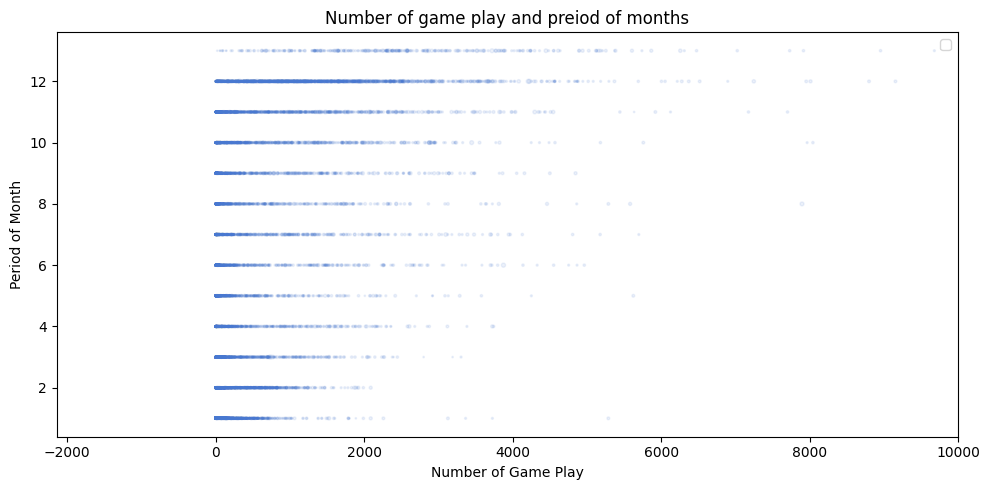

In [211]:
plt.figure(figsize=(10,5))
plt.scatter(play_recordes["playcount"], play_recordes["playduration"], s=play_recordes["numOfJoinedGuild"], alpha=0.1)
plt.title("Number of game play and preiod of months")
plt.xlim(right=10000)
plt.xlabel("Number of Game Play")
plt.ylabel("Period of Month")
plt.tight_layout()
plt.savefig("./images/scatter_gameplay_month_guildactivity.png")

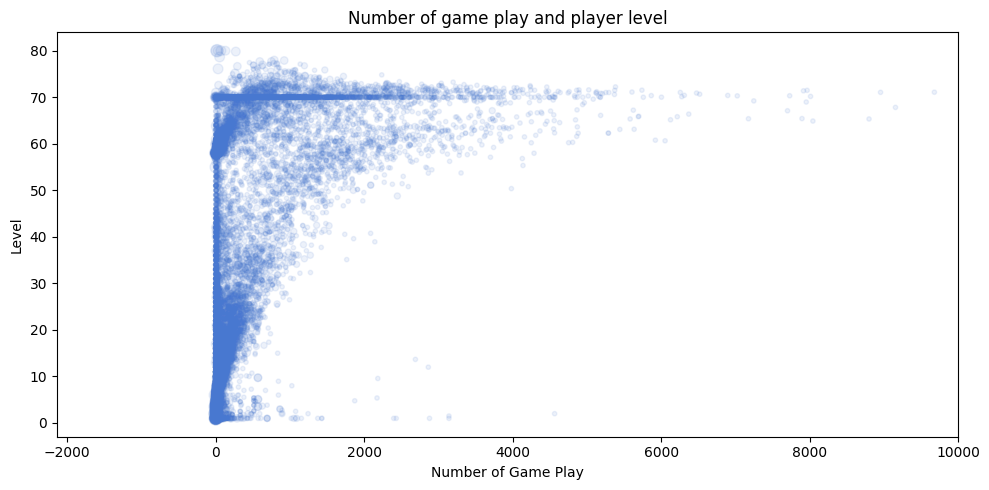

In [194]:
plt.figure(figsize=(10,5))
plt.scatter(play_recordes["playcount"], play_recordes["level"], s=play_recordes["numOfJoinedGuild"].sort_values()*10, alpha=0.1)
plt.title("Number of game play and player level")
plt.xlim(right=10000)
plt.xlabel("Number of Game Play")
plt.ylabel("Level")
plt.tight_layout()
plt.savefig("./images/scatter_gameplay_level_guildactivity.png")

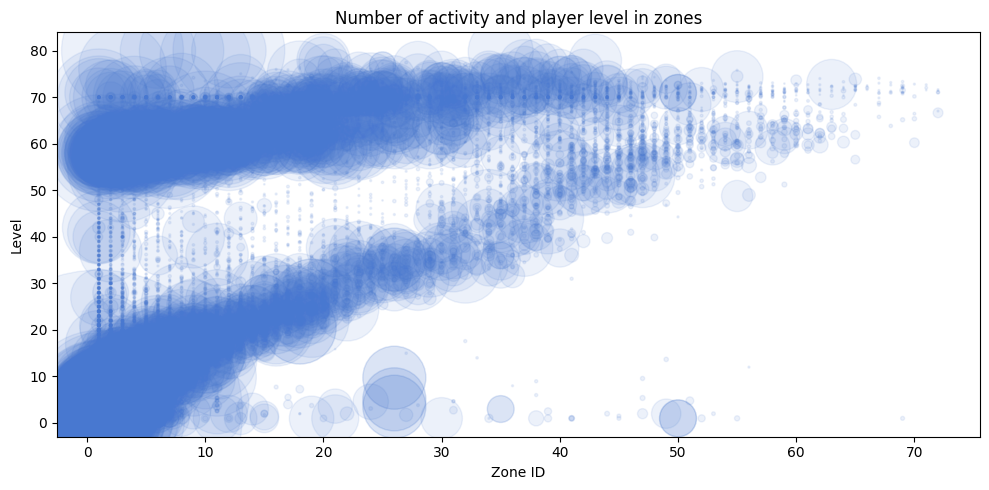

In [193]:
plt.figure(figsize=(10,5))
plt.scatter(play_recordes["zone"], play_recordes["level"], s=play_recordes["playcount"].sort_values(), alpha=0.1)
plt.title("Number of activity and player level in zones")
plt.xlabel("Zone ID")
plt.ylabel("Level")
plt.tight_layout()
plt.savefig("./images/scatter_numofJzone_ount.png")